# 1.올바른 시간 데이터 순서 확인

In [2]:
import pandas as pd

file_path = r'D:\MusicTrendAnalysis\data\daegeun_time_data.csv'
data = pd.read_csv(file_path)

data['date'] = pd.to_datetime(data['date'])
data = data.sort_values(by='date').reset_index(drop=True)

print(data.head())

   Unnamed: 0       date  Rank   Runtime  Weekly Views   n_score  g_score  \
0           0 2023-09-24     1 -0.733963      2.119452  0.942971     1.00   
1         123 2023-09-24   130  1.052141     -1.011885  0.104623     0.03   
2         124 2023-09-24   131  0.947076      0.413551  0.509538     0.30   
3         125 2023-09-24   132 -1.338086     -0.282185  0.496288     0.15   
4         126 2023-09-24   133 -0.024775      0.127099  0.250688     0.10   

   ky_chart_on  KoreanMovies  Dance  ...  Ballad  Soul  Rock  Pop  \
0            0             0      1  ...       0     0     0    0   
1            1             0      0  ...       1     0     0    0   
2            0             0      0  ...       0     0     1    0   
3            0             0      0  ...       0     0     0    1   
4            0             0      0  ...       0     0     1    0   

   season_autumn  season_spring  season_summer  season_winter  Previous_Rank  \
0              1              0           

# 2.지연기능 생성

In [3]:
lag_features = ['Rank', 'Weekly Views', 'n_score', 'g_score']

for feature in lag_features:
    data[f'{feature}_lag_1'] = data[feature].shift(1)
    data[f'{feature}_lag_2'] = data[feature].shift(2)
    data[f'{feature}_lag_3'] = data[feature].shift(3)

data = data.dropna().reset_index(drop=True)

print(data[['date', 'Rank', 'Rank_lag_1', 'Rank_lag_2', 'Rank_lag_3']].head())

        date  Rank  Rank_lag_1  Rank_lag_2  Rank_lag_3
0 2023-09-24   132       131.0       130.0         1.0
1 2023-09-24   133       132.0       131.0       130.0
2 2023-09-24   134       133.0       132.0       131.0
3 2023-09-24   135       134.0       133.0       132.0
4 2023-09-24   136       135.0       134.0       133.0


# 3.데이터 정규화

In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

columns_to_normalize = ['Rank', 'Weekly Views', 'n_score', 'g_score', 
                        'Rank_lag_1', 'Rank_lag_2', 'Rank_lag_3']

data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])

print(data[columns_to_normalize].head())

       Rank  Weekly Views   n_score  g_score  Rank_lag_1  Rank_lag_2  \
0  0.658291      0.102222  0.496288     0.15    0.653266    0.648241   
1  0.663317      0.159557  0.250688     0.10    0.658291    0.653266   
2  0.668342      0.171645  0.633998     0.10    0.663317    0.658291   
3  0.673367      0.000000  0.053410     0.04    0.668342    0.663317   
4  0.678392      0.199686  0.509538     0.30    0.673367    0.668342   

   Rank_lag_3  
0    0.000000  
1    0.648241  
2    0.653266  
3    0.658291  
4    0.663317  


# 4.LSTM모델 구축 및 교육

Epoch 1/50


C:\Users\user\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


246/246 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.1134 - val_loss: 0.0094
Epoch 2/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0116 - val_loss: 0.0084
Epoch 3/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0109 - val_loss: 0.0082
Epoch 4/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0110 - val_loss: 0.0083
Epoch 5/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0102 - val_loss: 0.0081
Epoch 6/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0105 - val_loss: 0.0085
Epoch 7/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0102 - val_loss: 0.0081
Epoch 8/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0094 - val_loss: 0.0081
Epoch 9/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0098 - val_loss: 0.0085
Epoch 10/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0091 - val_loss: 0.0081
Epoch 11/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0094 - val_loss: 0.0081
Epoch 12/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.

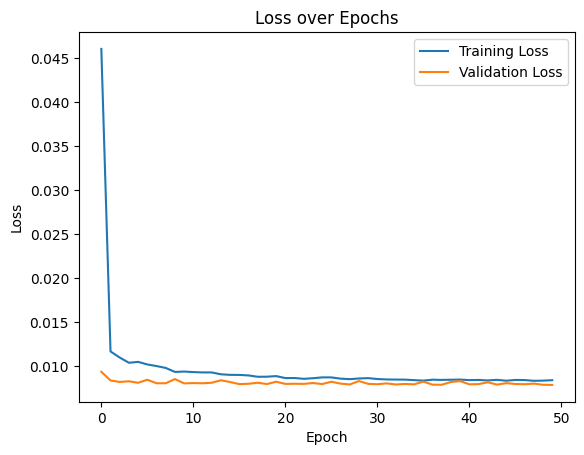

In [5]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Prepare the data for the LSTM model
# Define the input features and the target variable (Rank)
features = ['Weekly Views', 'n_score', 'g_score', 'Rank_lag_1', 'Rank_lag_2', 'Rank_lag_3']
target = 'Rank'

# Split data into input (X) and output (y)
X = data[features].values
y = data[target].values

# Reshape the input to be 3D for LSTM: (samples, timesteps, features)
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))  # 1 timestep for each input sample

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))  # Adding dropout to prevent overfitting
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(1))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X, y, epochs=50, batch_size=32, validation_split=0.2)

# Plot training history
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


# 5.모델 평가 및 예측하기

In [8]:
rank_scaler = MinMaxScaler()

data['Rank'] = rank_scaler.fit_transform(data[['Rank']])

columns_to_normalize = ['Weekly Views', 'n_score', 'g_score', 'Rank_lag_1', 'Rank_lag_2', 'Rank_lag_3']
data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])

  1/308 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step

308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


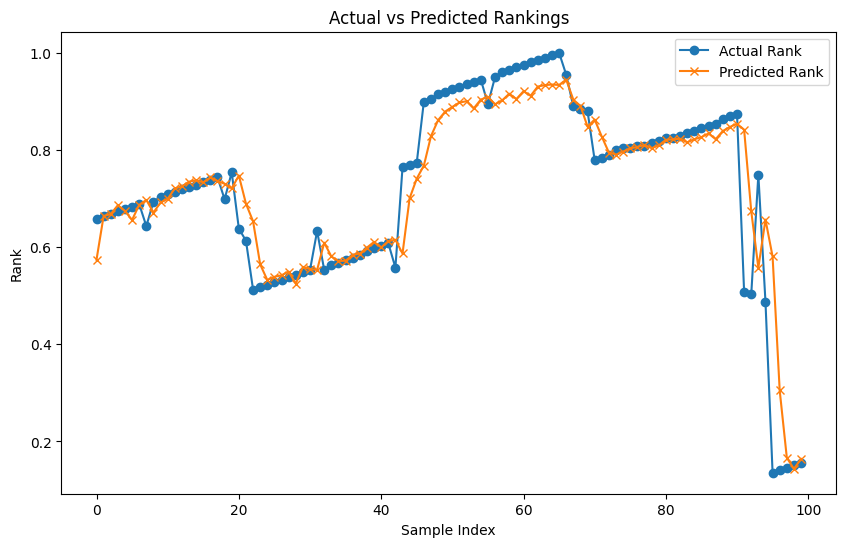

In [9]:
# Make predictions on the training set (or use a test set if available)
predictions = model.predict(X)

# Rescale the predictions back to the original scale (if you used MinMaxScaler)
predictions_rescaled = rank_scaler.inverse_transform(predictions)

# Compare predicted rankings with actual rankings
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(rank_scaler.inverse_transform(y[:100].reshape(-1, 1)), label='Actual Rank', marker='o')  
# Actual rankings (first 100 data points)
plt.plot(predictions_rescaled[:100], label='Predicted Rank', marker='x')  
# Predicted rankings (first 100 data points)
plt.xlabel('Sample Index')
plt.ylabel('Rank')
plt.title('Actual vs Predicted Rankings')
plt.legend()
plt.show()


# 6.하이퍼 파라미터 튜닝 구현

Epoch 1/100


C:\Users\user\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


246/246 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1411 - val_loss: 0.0095
Epoch 2/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0143 - val_loss: 0.0090
Epoch 3/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0128 - val_loss: 0.0086
Epoch 4/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0126 - val_loss: 0.0084
Epoch 5/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0124 - val_loss: 0.0086
Epoch 6/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0122 - val_loss: 0.0088
Epoch 7/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0112 - val_loss: 0.0085
Epoch 8/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0109 - val_loss: 0.0081
Epoch 9/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0107 - val_loss: 0.0086
Epoch 10/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0108 - val_loss: 0.0081
Epoch 11/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0099 - val_loss: 0.0082
Epoch 12/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

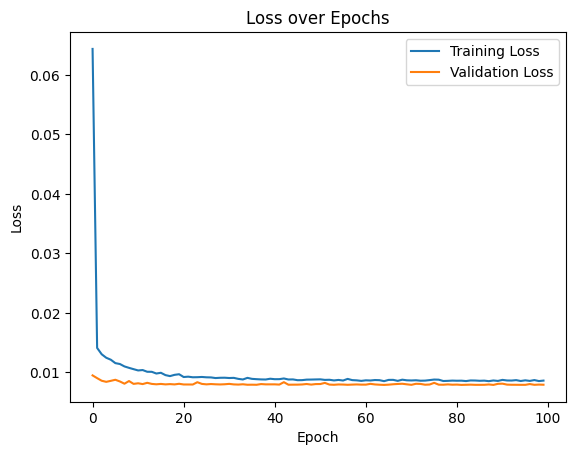

In [10]:
from tensorflow.keras.optimizers import Adam

def build_lstm_model(units=50, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))  # Output layer for Rank prediction

    # Compile the model with Adam optimizer
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Set hyperparameters
units = 60
dropout_rate = 0.3
learning_rate = 0.0005
batch_size = 32
epochs = 100

# Build and compile the model
model = build_lstm_model(units=units, dropout_rate=dropout_rate, learning_rate=learning_rate)

# Train the model
history = model.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=0.2)

# Plot the loss history to visualize training progress
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# 7. 모델 예측 및 비교 및 비교

308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


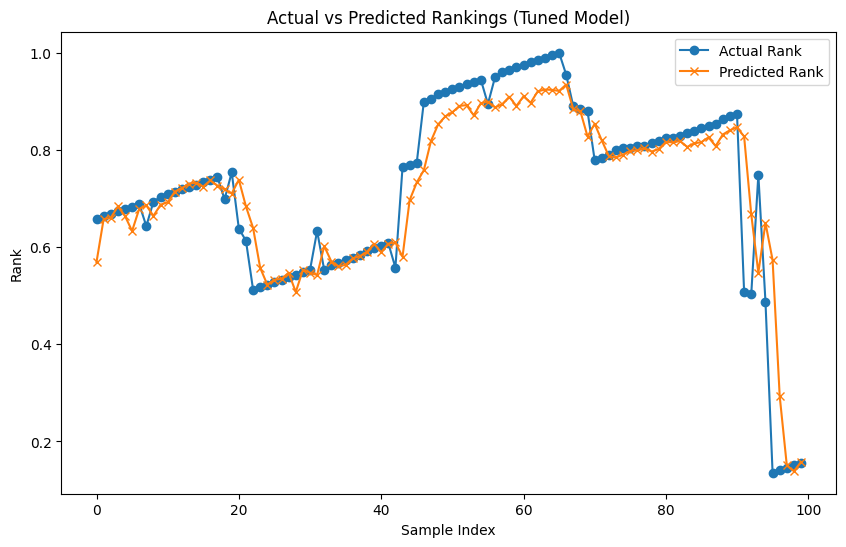

In [11]:
# Make predictions with the tuned model
predictions = model.predict(X)

# Inverse transform the predicted Rank values
predictions_rescaled = rank_scaler.inverse_transform(predictions)

# Compare the predicted rankings with actual rankings
plt.figure(figsize=(10, 6))
plt.plot(rank_scaler.inverse_transform(y[:100].reshape(-1, 1)), label='Actual Rank', marker='o')  # Actual rankings (first 100 data points)
plt.plot(predictions_rescaled[:100], label='Predicted Rank', marker='x')  # Predicted rankings (first 100 data points)
plt.xlabel('Sample Index')
plt.ylabel('Rank')
plt.title('Actual vs Predicted Rankings (Tuned Model)')
plt.legend()
plt.show()

# 8.하이퍼파라미터 검색 정의

In [12]:
# 스텝 1
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Define the hyperparameter values to search
units_list = [40, 60, 100]
dropout_rates = [0.2, 0.3, 0.4]
learning_rates = [0.001, 0.0005, 0.0001]
batch_sizes = [32, 64]
epochs = 100  # Set a reasonable number of epochs

# Track the results of each combination
results = []

# Loop through each combination of hyperparameters
for units in units_list:
    for dropout_rate in dropout_rates:
        for learning_rate in learning_rates:
            for batch_size in batch_sizes:
                print(f"Training with units={units}, dropout_rate={dropout_rate}, learning_rate={learning_rate}, batch_size={batch_size}")

                # Build and compile the LSTM model with current hyperparameters
                model = build_lstm_model(units=units, dropout_rate=dropout_rate, learning_rate=learning_rate)

                # Train the model and save history
                history = model.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0)

                # Record the final validation loss
                final_val_loss = history.history['val_loss'][-1]
                results.append({
                    'units': units,
                    'dropout_rate': dropout_rate,
                    'learning_rate': learning_rate,
                    'batch_size': batch_size,
                    'val_loss': final_val_loss
                })

                print(f"Final Validation Loss: {final_val_loss}")

# Display the results sorted by validation loss
sorted_results = sorted(results, key=lambda x: x['val_loss'])

# Print the best configuration
print("Best configuration:")
print(sorted_results[0])


Training with units=40, dropout_rate=0.2, learning_rate=0.001, batch_size=32


C:\Users\user\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Final Validation Loss: 0.007917032577097416
Training with units=40, dropout_rate=0.2, learning_rate=0.001, batch_size=64
Final Validation Loss: 0.00812623929232359
Training with units=40, dropout_rate=0.2, learning_rate=0.0005, batch_size=32
Final Validation Loss: 0.007934258319437504
Training with units=40, dropout_rate=0.2, learning_rate=0.0005, batch_size=64
Final Validation Loss: 0.008044343441724777
Training with units=40, dropout_rate=0.2, learning_rate=0.0001, batch_size=32
Final Validation Loss: 0.008037461899220943
Training with units=40, dropout_rate=0.2, learning_rate=0.0001, batch_size=64
Final Validation Loss: 0.008007755503058434
Training with units=40, dropout_rate=0.3, learning_rate=0.001, batch_size=32
Final Validation Loss: 0.007925706915557384
Training with units=40, dropout_rate=0.3, learning_rate=0.001, batch_size=64
Final Validation Loss: 0.00798245519399643
Training with units=40, dropout_rate=0.3, learning_rate=0.0005, batch_size=32
Final Validation Loss: 0.0079

# 10.최적의 하이퍼파라미터로 최종 모델 학습

Epoch 1/100


C:\Users\user\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


246/246 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1075 - val_loss: 0.0089
Epoch 2/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0113 - val_loss: 0.0083
Epoch 3/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0106 - val_loss: 0.0083
Epoch 4/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0109 - val_loss: 0.0081
Epoch 5/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0095 - val_loss: 0.0081
Epoch 6/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0101 - val_loss: 0.0081
Epoch 7/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0098 - val_loss: 0.0081
Epoch 8/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0102 - val_loss: 0.0081
Epoch 9/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0099 - val_loss: 0.0081
Epoch 10/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0093 - val_loss: 0.0080
Epoch 11/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0097 - val_loss: 0.0081
Epoch 12/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

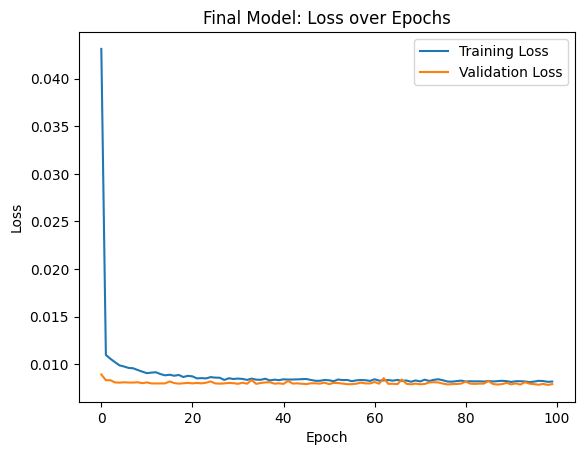

In [13]:
# 스텝 3

# Extract the best hyperparameters
best_params = sorted_results[0]
best_units = best_params['units']
best_dropout = best_params['dropout_rate']
best_learning_rate = best_params['learning_rate']
best_batch_size = best_params['batch_size']

# Train the final model with optimal hyperparameters
final_model = build_lstm_model(units=best_units, dropout_rate=best_dropout, learning_rate=best_learning_rate)
history = final_model.fit(X, y, epochs=epochs, batch_size=best_batch_size, validation_split=0.2)

# Plot the final model's training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Final Model: Loss over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


# 11.최적의 하이퍼파라미터를 사용하여 모델 재교육

Epoch 1/100
308/308 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0842
Epoch 2/100
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0117
Epoch 3/100
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0108
Epoch 4/100
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0106
Epoch 5/100
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0097
Epoch 6/100
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0090
Epoch 7/100
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0087
Epoch 8/100
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0089
Epoch 9/100
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0088
Epoch 10/100
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0096
Epoch 11/100
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0089
Epoch 12/100
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0088
Epoch 13/100
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0088
Epoch 14/100
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0086
Epoch 15/100
308/308 ━━━━━━━━━━━━━━━━━━━━ 1

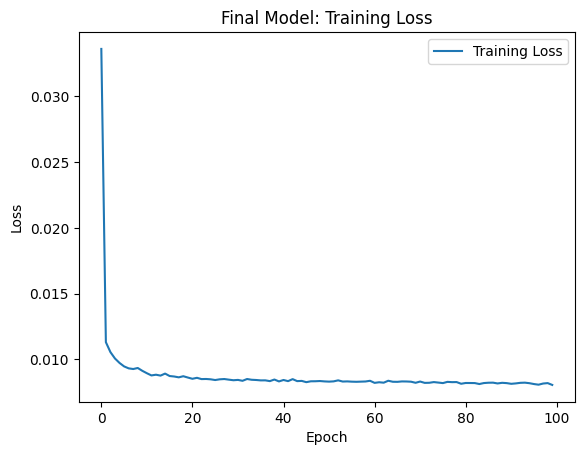

In [14]:
# Build the final model with optimal hyperparameters
final_model = build_lstm_model(units=60, dropout_rate=0.2, learning_rate=0.001)

# Train the model on the entire dataset (no validation split)
final_history = final_model.fit(X, y, epochs=100, batch_size=32, verbose=1)

# Plot the training loss to verify training stability
plt.plot(final_history.history['loss'], label='Training Loss')
plt.title('Final Model: Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


# 12.테스트 데이터에 대한 예측하기

308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


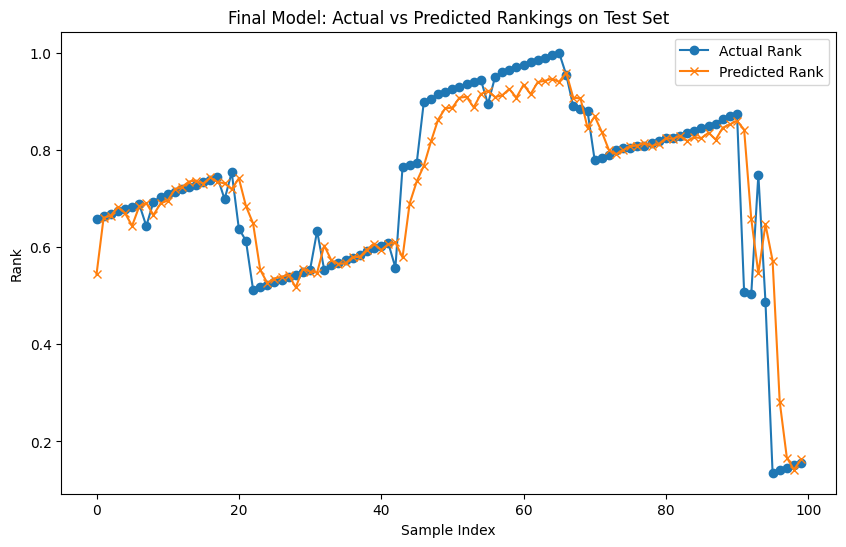

In [15]:
# Assuming you have test data (replace this with your actual test dataset)
# Preprocess test data in the same way as training data
# test_X = preprocess_test_data(test_data)

# Make predictions on the test set
test_predictions = final_model.predict(X)  # Replace 'X' with your test data 'test_X'

# Inverse transform the predicted Rank values back to their original scale
test_predictions_rescaled = rank_scaler.inverse_transform(test_predictions)

# Inverse transform the actual test Rank values for comparison
actual_rescaled = rank_scaler.inverse_transform(y.reshape(-1, 1))  # Replace 'y' with actual test values

# Compare predicted and actual rankings on the test set
plt.figure(figsize=(10, 6))
plt.plot(actual_rescaled[:100], label='Actual Rank', marker='o')  # Actual rankings (first 100 data points)
plt.plot(test_predictions_rescaled[:100], label='Predicted Rank', marker='x')  # Predicted rankings (first 100 data points)
plt.xlabel('Sample Index')
plt.ylabel('Rank')
plt.title('Final Model: Actual vs Predicted Rankings on Test Set')
plt.legend()
plt.show()

# 13. 모델 성능 및 평가

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate Mean Squared Error (MSE) and Mean Absolute Error (MAE)
mse = mean_squared_error(actual_rescaled, test_predictions_rescaled)
mae = mean_absolute_error(actual_rescaled, test_predictions_rescaled)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")

Mean Squared Error (MSE): 0.007412045568111793
Mean Absolute Error (MAE): 0.044765484689662884
